In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### Code Explanation: Take 1

# 1. Parameter Setup
In the model of stasis, arguably the most important parameters are $\alpha$, $\gamma$, and $\delta$. 

$\alpha = 1$ is the power law variable that controls the intial abundance scaling. 

$\gamma = 7$ is the power law variable controlling decay rate scaling

$\delta = 1$ is the power law variable controlling the mass spacing for the tower of particles

Then, we have the parameters that describe the mass of the lightest particle ($m_0$) and the number of particles in the tower ($N$)





In [2]:
'''import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)


# =============================
# 1. Define model parameters
# =============================
alpha = 1
gamma = 7
delta = 1
m0 = 1.0
Delta_m = m0 
N_species = 50
Gamma_Nminus1_over_H0 = 0.01 # 0.01

# Prepare masses & decay rates
ell_values = np.arange(N_species)
m_ell      = m0 + Delta_m*(ell_values)**delta
m_Nminus1  = m_ell[-1]
Gamma0     = Gamma_Nminus1_over_H0 / ((m_Nminus1/m0)**gamma)
Gamma_ell  = Gamma0 * (m_ell/m0)**gamma

# Initial conditions in log form
# tiny_radiation   = 1e0
tiny_radiation = 0.01
Omega_ell_initial = (m_ell/m0)**alpha
Omega_ell_initial /= Omega_ell_initial.sum()
Omega_ell_initial *= (1-tiny_radiation)
chi_ell0   = np.log(Omega_ell_initial)
chi_gamma0 = np.log(tiny_radiation)
N0         = 0.0  # start at 0 e-folds

# print(chi_ell0)

# Now y = [chi_ell(0..N_species-1), chi_gamma, N]
y0 = np.concatenate([chi_ell0, [chi_gamma0, N0]])

# Stop when N hits N_max
N_max = 30.0
def event_N_max(t, y):
    return y[-1] - N_max
event_N_max.terminal = True
event_N_max.direction = 1

# =============================
# 2. ODE in t
# =============================
def ode_system_in_time(t, y):
    chi_ell  = y[:N_species]
    chi_gamma= y[N_species]
    N        = y[N_species+1]
    
    rho_ell  = np.exp(chi_ell)
    rho_gamma= np.exp(chi_gamma)
    rho_tot  = rho_ell.sum() + rho_gamma
    H        = np.sqrt(rho_tot/3.0)
    
    # dχ_ell/dt = H * (-3 - Γ_ell/H) = -3H - Γ_ell
    dchi_ell   = -3.0*H - Gamma_ell
    
    # sum_decay = Σ (Γ_ell/H) e^(χ_ell - χ_γ)
    sum_decay  = np.sum((Gamma_ell/H) * np.exp(chi_ell - chi_gamma))
    # dχ_γ/dt = H * (-4 + sum_decay) = -4H + H*sum_decay
    # but H*sum_decay = Σ Γ_ell e^(χ_ell - χ_γ)
    dchi_gamma = -4.0*H + H * sum_decay#np.sum(Gamma_ell * np.exp(chi_ell - chi_gamma))
    
    # dN/dt = H
    dN_dt = H
    
    return np.concatenate([dchi_ell, [dchi_gamma, dN_dt]])

# =============================
# 3. Solve in time
# =============================
t_span = (1e-8, 1e15)  # large enough—event will stop us at N=30
sol = solve_ivp(
    ode_system_in_time,
    t_span, y0,
    method='BDF',
    rtol=1e-8, atol=1e-12,
    events=[event_N_max]
)

# y0_new = np.load("checkpoint_75pct.npy")
# sol = solve_ivp(
#     ode_system_in_time,
#     t_span, y0_new,
#     method='BDF',
#     rtol=1e-8, atol=1e-12,
#     events=[event_N_max]
# )

# =============================
# 4. Extract and plot vs N
# =============================
chi_ell_sol   = sol.y[:N_species, :]    # (N_species, len)
chi_gamma_sol = sol.y[N_species, :]     # (len,)
N_sol         = sol.y[N_species+1, :]   # (len,)

# print(N_sol)

# print(chi_ell_sol[37] == start_middle)
# start_middle = sol.y[38,:]
# start_middle = 
# print(sol.y[:,[38]])


time = sol.t

rho_ell_sol   = np.exp(chi_ell_sol)
rho_gamma_sol = np.exp(chi_gamma_sol)
rho_tot_sol   = rho_ell_sol.sum(axis=0) + rho_gamma_sol

m_sol = rho_ell_sol.sum(axis=0)

Omega_M       = rho_ell_sol.sum(axis=0) / rho_tot_sol
Omega_gamma   = rho_gamma_sol / rho_tot_sol
Omega_ell_sol = rho_ell_sol / rho_tot_sol

# # --- Figure 1: total M vs γ ---
# plt.figure(figsize=(10,6))
# plt.plot(time, m_sol, label=r'$\rho_M$')
# plt.plot(time, rho_gamma_sol, label=r'$\rho_\gamma$')
# plt.plot(time, rho_tot_sol, label=r'$\rho_{tot}$')

# plt.xlabel(r'Cosmic Time $t$')
# plt.ylabel(r'Abundance $\Omega$')
# plt.title('Matter-Radiation Stasis (Log-Density Variables)')
# plt.grid(True)
# plt.legend()

# plt.xlim(1e-5,1e12)
# plt.xscale('log')
# plt.yscale('log')

# plt.show()

# --- Figure 2: individual species (linear) ---
plt.figure(figsize=(10,6))
for i in range(N_species):
    plt.plot(time, Omega_ell_sol[i], color='orange', alpha=0.5)
plt.plot(time, Omega_M,    color='red',   linewidth=2, label=r'$\Omega_M$')
plt.plot(time, Omega_gamma,color='blue',  linewidth=2, label=r'$\Omega_\gamma$')
# plt.xlabel(r'$N$')
# plt.ylabel('Abundance')
plt.xlabel(r'Cosmic Time $t$')
plt.ylabel(r'Abundance $\Omega$')
plt.ylim(0,1.05)
# plt.xscale("log")
plt.title('Individual Matter Species (Linear Scale)')
plt.legend(loc='best')
plt.grid(True)

plt.xlim(1,1e15)
plt.xscale('log')


plt.show()'''


'import numpy as np\nfrom scipy.integrate import solve_ivp\nimport matplotlib.pyplot as plt\n\nnp.set_printoptions(threshold=np.inf)\n\n\n# =============================\n# 1. Define model parameters\n# =============================\nalpha = 1\ngamma = 7\ndelta = 1\nm0 = 1.0\nDelta_m = m0 \nN_species = 50\nGamma_Nminus1_over_H0 = 0.01 # 0.01\n\n# Prepare masses & decay rates\nell_values = np.arange(N_species)\nm_ell      = m0 + Delta_m*(ell_values)**delta\nm_Nminus1  = m_ell[-1]\nGamma0     = Gamma_Nminus1_over_H0 / ((m_Nminus1/m0)**gamma)\nGamma_ell  = Gamma0 * (m_ell/m0)**gamma\n\n# Initial conditions in log form\n# tiny_radiation   = 1e0\ntiny_radiation = 0.01\nOmega_ell_initial = (m_ell/m0)**alpha\nOmega_ell_initial /= Omega_ell_initial.sum()\nOmega_ell_initial *= (1-tiny_radiation)\nchi_ell0   = np.log(Omega_ell_initial)\nchi_gamma0 = np.log(tiny_radiation)\nN0         = 0.0  # start at 0 e-folds\n\n# print(chi_ell0)\n\n# Now y = [chi_ell(0..N_species-1), chi_gamma, N]\ny0 = np.co

In [3]:
# 75% of the recorded timesteps
'''i75 = int(0.75 * sol.t.size)

# extract the full state-vector y at that index
y75 = sol.y[:, i75]
t75   = sol.t[i75]

print(f"At t={sol.t[i75]:.3e},  N={y75[-1]:.3f}")
# y75 contains [chi₀…chi_{N−1}, chi_γ, N]

# now save to disk for later:
np.save("checkpoint_75pct.npy", y75)'''

'i75 = int(0.75 * sol.t.size)\n\n# extract the full state-vector y at that index\ny75 = sol.y[:, i75]\nt75   = sol.t[i75]\n\nprint(f"At t={sol.t[i75]:.3e},  N={y75[-1]:.3f}")\n# y75 contains [chi₀…chi_{N−1}, chi_γ, N]\n\n# now save to disk for later:\nnp.save("checkpoint_75pct.npy", y75)'

In [4]:
# Need to convert cosmic time to seconds. Right now my H0 and m are dimensionless
# Pehaps I can set their initial conditions to be from the start of PRyMordial

# maybe also track densities?

In [5]:
y0_new = np.load("checkpoint_75pct.npy")
print(y0_new)

[-4.98737386e+01 -4.92165148e+01 -4.93934617e+01 -5.31215656e+01
 -7.03625792e+01 -1.27264837e+02 -2.80876224e+02 -6.40997754e+02
 -1.40059443e+03 -2.87618673e+03 -5.55964765e+03 -1.01828306e+04
 -1.77964535e+04 -2.98646653e+04 -4.83767191e+04 -7.59771796e+04
 -1.16116088e+05 -1.73220512e+05 -2.52888906e+05 -3.62109707e+05
 -5.09505590e+05 -7.05604810e+05 -9.63141063e+05 -1.29738327e+06
 -1.72649676e+06 -2.27193718e+06 -2.95887867e+06 -3.81667770e+06
 -4.87937387e+06 -6.18622935e+06 -7.78230809e+06 -9.71909648e+06
 -1.20551667e+07 -1.48568845e+07 -1.81991619e+07 -2.21662580e+07
 -2.68526276e+07 -3.23638194e+07 -3.88174264e+07 -4.63440884e+07
 -5.50885489e+07 -6.52107675e+07 -7.68870895e+07 -9.03114736e+07
 -1.05696780e+08 -1.23276120e+08 -1.43304265e+08 -1.66059128e+08
 -1.91843300e+08 -2.20985660e+08 -4.83521503e+01  1.42409181e+01]


[[0.01806031 0.01806304 0.01806585 ... 0.         0.         0.        ]
 [0.03612062 0.03612607 0.03613169 ... 0.         0.         0.        ]
 [0.05418087 0.05418905 0.05419747 ... 0.         0.         0.        ]
 ...
 [0.14433105 0.14434291 0.14435476 ... 0.         0.         0.        ]
 [0.16215453 0.16215354 0.16215161 ... 0.         0.         0.        ]
 [0.17970233 0.17967045 0.17963549 ... 0.         0.         0.        ]]


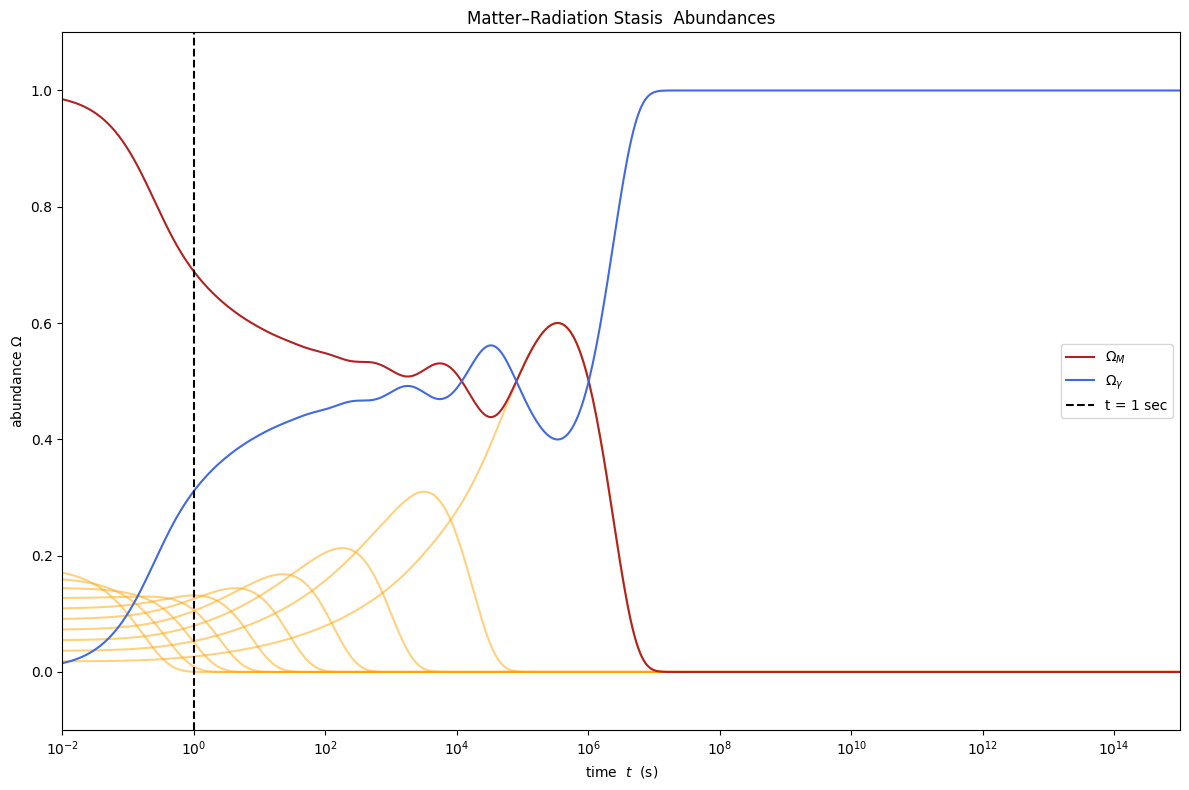

In [15]:
"""
Stasis tower + radiation in bona-fide SI seconds
------------------------------------------------
* radiation starts at ρ_γ = 35 320 MeV⁴  (T₀ = 10 MeV, g* = 10.75)
* tower adds an extra ρ_M ≃ 3.53×10⁷ MeV⁴  (tiny_radiation = 10⁻³)
* Γ/H for the heaviest mode is 0.01 at t₀
* ODE is solved with t in **seconds**
"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


# ------------------------------------------------------------------
# Physical constants and helpers
# ------------------------------------------------------------------
# HBAR_MEV_S = 6.582_119_569e-22             # ħ (MeV·s)
# MPL_MEV    = 1.2209e22                     # reduced Planck mass (MeV)
Kelvin = 1. # temperature unit
second = 1. # [CGS unit]
cm = 1. # [CGS unit]
gram = 1. # [CGS unit]
erg = gram*cm**2/second # [CGS unit]
kB = 1.380649*1.e-16*erg/Kelvin # Boltzmann constant, PDG
clight = 2.99792458*1.e+10*cm/second # speed of light, PDG
hbar = 6.62607015/(2*np.pi)*1.e-27*erg*second
GN = 6.70883*1.e-39*1.e-6 # Newton constant in [MeV-2]
Mpl = 1./np.sqrt(GN) # Planck mass in [MeV], PDG
MeV = 1.602176634*1.e-6*erg

MeV_to_secm1 = MeV/hbar

def mev_to_inv_s(x_mev):
    """Convert an energy (MeV) to a frequency (s⁻¹)."""
    return x_mev / hbar


# ------------------------------------------------------------------
# 1.  Model parameters
# ------------------------------------------------------------------
alpha   = 1
gamma   = 7
delta   = 1
m0      = 1e0            # 1 GeV in MeV
Delta_m = m0
N_SPECIES = 10 #10
GAMMA_OVER_H = 0.01 #1e6        # Γ/H of the *heaviest* species at t₀

T0_MEV   = 10.0
g_star   = 10.75
rho_gamma0 = (np.pi**2/30) * g_star * T0_MEV**4     # 35 320 MeV⁴

tiny_radiation = 0.01 # 1e-3      # ρ_γ / ρ_tot  at t₀
rho_tot0 = rho_gamma0 / tiny_radiation
rho_M0   = rho_tot0 - rho_gamma0

ell      = np.arange(N_SPECIES)
m_ell    = m0 + Delta_m*ell

omega_ell_frac = (m_ell/m0)**alpha
omega_ell_frac /= omega_ell_frac.sum()
rho_ell0 = omega_ell_frac * rho_M0                 # vector (MeV⁴)


# ------------------------------------------------------------------
# 2.  Decay widths  (Γ in s⁻¹)
# ------------------------------------------------------------------
# H0_mev   = np.sqrt(rho_tot0) / (np.sqrt(3)*MPL_MEV)    # MeV
# H0_mev = np.sqrt(rho_tot0) / (np.sqrt(3)*Mpl) 
# H0_s = mev_to_inv_s(H0_mev)                        # s⁻¹

H0_mev = np.sqrt(8*np.pi*GN/3 * rho_tot0)
H0_s = MeV_to_secm1 * np.sqrt(8*np.pi*GN/3 * rho_tot0)

m_Nm1    = m_ell[-1]
Gamma0_mev = (GAMMA_OVER_H / (m_Nm1/m0)**gamma) * H0_mev # This is not needed. I am dividinv and multiplying by H0. so it should just be gamma
Gamma_ell = Gamma0_mev * (m_ell/m0)**gamma            # MeV
# Gamma_ell_s = mev_to_inv_s(Gamma_ell)                 # s⁻¹
Gamma_ell_s = MeV_to_secm1 * Gamma_ell


# ------------------------------------------------------------------
# 3.  Initial state (log-densities)  — still *in MeV⁴*
# ------------------------------------------------------------------
chi_ell0   = np.log(rho_ell0)
chi_gamma0 = np.log(rho_gamma0)
N0         = 0.0
y0 = np.concatenate([chi_ell0, [chi_gamma0, N0]])


# ------------------------------------------------------------------
# 4.  ODE system with t in seconds
# ------------------------------------------------------------------
def ode_system(t, y):
    chi_ell   = y[:N_SPECIES]
    chi_gamma = y[N_SPECIES]
    N         = y[N_SPECIES+1]

    rho_ell = np.exp(chi_ell)           # still MeV⁴
    rho_g   = np.exp(chi_gamma)
    rho_tot = rho_ell.sum() + rho_g

    # H_mev = np.sqrt(rho_tot) / (np.sqrt(3)*MPL_MEV)   # MeV
    # H_s   = mev_to_inv_s(H_mev)                       # convert to s⁻¹
    H_s = MeV_to_secm1 * np.sqrt(8*np.pi*GN/3 * rho_tot)

    dchi_ell   = -3.0*H_s - Gamma_ell_s

    # sum_decay  = np.sum((Gamma_ell/H) * np.exp(chi_ell - chi_gamma))

    dchi_gamma = -4.0*H_s + np.sum(Gamma_ell_s * np.exp(chi_ell - chi_gamma))
    dNdt       = H_s

    # print(H_s / MeV_to_secm1)

    return np.concatenate([dchi_ell, [dchi_gamma, dNdt]])


# ------------------------------------------------------------------
# 5.  Integrate up to 1 s  (covers the entire BBN window)
# ------------------------------------------------------------------
t_span = (0.0, 1e30)            # seconds
tini = 1. / (2. * H0_s)
sol_thermo_sampling = np.logspace(np.log10(tini),np.log10(t_span[1]),1200)
sol = solve_ivp(
    ode_system,
    t_span,
    y0,
    t_eval=sol_thermo_sampling,
    method='BDF',
    rtol=1e-8,
    atol=1e-12
)


# ------------------------------------------------------------------
# 6.  Unpack & plot
# ------------------------------------------------------------------
t = sol.t                       # seconds
rho_ell = np.exp(sol.y[:N_SPECIES])
rho_g   = np.exp(sol.y[N_SPECIES])
rho_tot = rho_ell.sum(axis=0) + rho_g

Omega_M = rho_ell.sum(axis=0) / rho_tot
Omega_g = rho_g                / rho_tot
Omega_ell_sol = rho_ell / rho_tot

print(Omega_ell_sol)

plt.figure(figsize=(12,8))
for i in range(N_SPECIES):
    plt.plot(t, Omega_ell_sol[i], color='orange', alpha=0.5)
plt.semilogx(t, Omega_M, label=r'$\Omega_M$', color='firebrick')
plt.semilogx(t, Omega_g, label=r'$\Omega_\gamma$', color='royalblue')
plt.xlabel(r'time  $t$  (s)')
plt.ylabel(r'abundance $\Omega$')
plt.title('Matter–Radiation Stasis  Abundances')
plt.ylim(-0.1, 1.1)

plt.xlim(1e-2, 1e15)

plt.axvline(x=1e0, color='black', linestyle='--', label='t = 1 sec')

plt.legend()
plt.tight_layout()
plt.show()


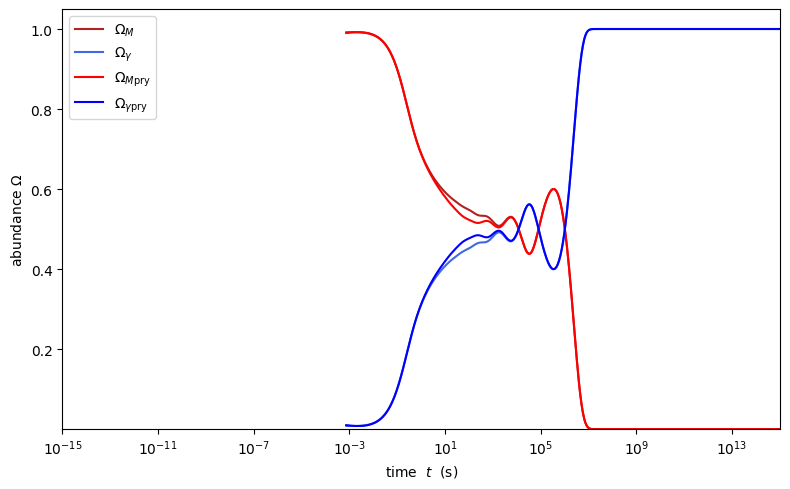

In [16]:
t1, Tg1, rho_tot1, rho_rad1, rho_dm1, Omega_m1, Omega_rad1= \
    np.loadtxt("../PRyMrates/thermo/stasis_abundances.txt", unpack=True, skiprows=1)


plt.figure(figsize=(8,5))
plt.semilogx(t, np.array(Omega_M), label=r'$\Omega_M$', color='firebrick')
plt.semilogx(t, np.array(Omega_g), label=r'$\Omega_\gamma$', color='royalblue')
plt.semilogx(t1, Omega_m1, label=r'$\Omega_{M \rm{pry}}$', color='red')
plt.semilogx(t1, Omega_rad1, label=r'$\Omega_{\gamma \rm{pry}}$', color='blue')
plt.xlabel(r'time  $t$  (s)')
plt.ylabel(r'abundance $\Omega$')
#plt.title('Matter–Radiation Stasis  Abundances')
plt.ylim(1e-4, 1.05)

# plt.xlim(1e-10, 1e3)
plt.xlim(min(t),max(t))
plt.xlim(1e-15,1e15)
#plt.xlim(1e-2,1e7)
#plt.ylim(0,1)
#plt.axvline(x=1e0, color='black', linestyle='--', label='t = 1 sec')

plt.legend()
plt.tight_layout()
plt.show()

4.458370675179971e-19
4.458370675179971e-19


[2.23409355e-19 2.21239460e-19 2.19069864e-19 2.16900979e-19
 2.14733214e-19 2.12566978e-19 2.10402678e-19 2.08240722e-19
 2.06081513e-19 2.03925454e-19 2.01772946e-19 1.99624385e-19
 1.97480167e-19 1.95340683e-19 1.93206320e-19 1.91077463e-19
 1.88954492e-19 1.86837783e-19 1.84727706e-19 1.82624629e-19
 1.80528912e-19 1.78440912e-19 1.76360978e-19 1.74289457e-19
 1.72226686e-19 1.70172998e-19 1.68128721e-19 1.66094173e-19
 1.64069669e-19 1.62055514e-19 1.60052008e-19 1.58059443e-19
 1.56078105e-19 1.54108270e-19 1.52150209e-19 1.50204184e-19
 1.48270450e-19 1.46349255e-19 1.44440836e-19 1.42545426e-19
 1.40663246e-19 1.38794514e-19 1.36939434e-19 1.35098207e-19
 1.33271023e-19 1.31458064e-19 1.29659505e-19 1.27875512e-19
 1.26106244e-19 1.24351851e-19 1.22612474e-19 1.20888248e-19
 1.19179299e-19 1.17485744e-19 1.15807694e-19 1.14145251e-19
 1.12498511e-19 1.10867560e-19 1.09252477e-19 1.07653335e-19
 1.06070198e-19 1.04503124e-19 1.02952163e-19 1.01417358e-19
 9.98987449e-20 9.839635

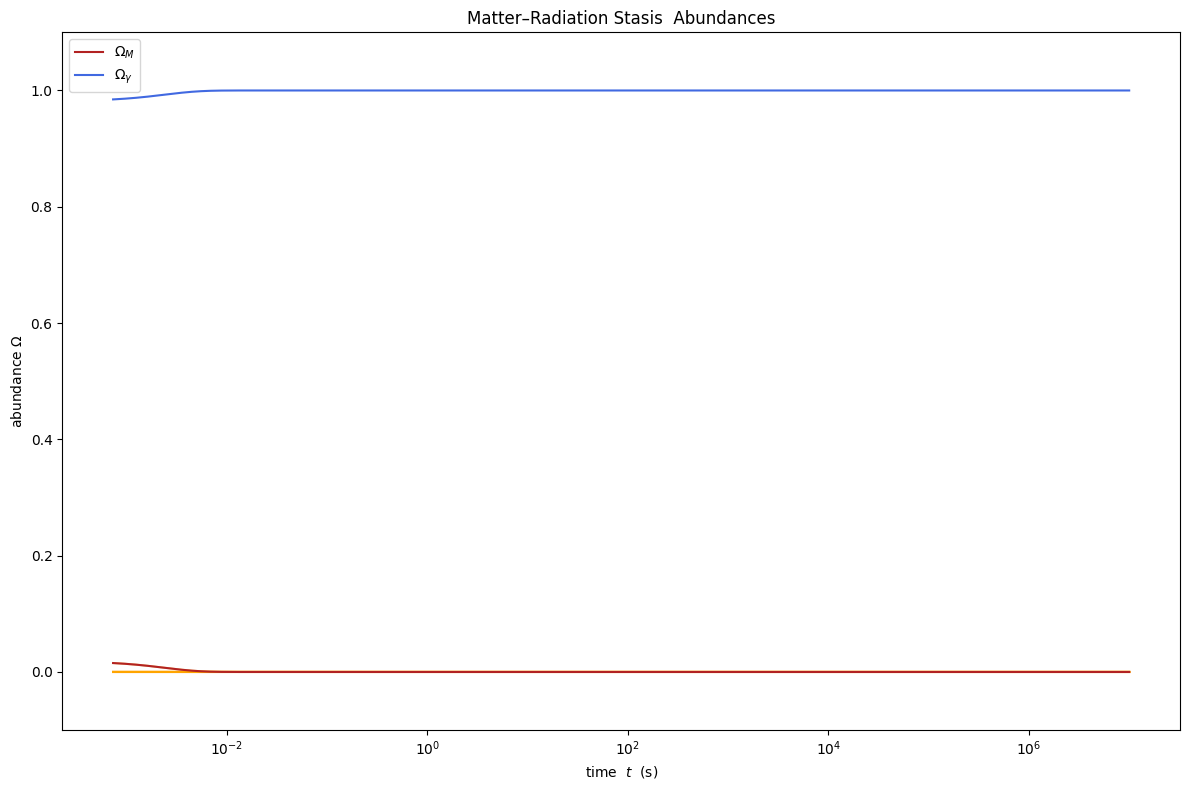

In [ ]:
"""
Stasis tower + radiation in bona-fide SI seconds
------------------------------------------------
* radiation starts at ρ_γ = 35 320 MeV⁴  (T₀ = 10 MeV, g* = 10.75)
* tower adds an extra ρ_M ≃ 3.53×10⁷ MeV⁴  (tiny_radiation = 10⁻³)
* Γ/H for the heaviest mode is 0.01 at t₀
* ODE is solved with t in **seconds**
"""

'''import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


# ------------------------------------------------------------------
# Physical constants and helpers
# ------------------------------------------------------------------
# HBAR_MEV_S = 6.582_119_569e-22             # ħ (MeV·s)
# MPL_MEV    = 1.2209e22                     # reduced Planck mass (MeV)
Kelvin = 1. # temperature unit
second = 1. # [CGS unit]
cm = 1. # [CGS unit]
gram = 1. # [CGS unit]
erg = gram*cm**2/second # [CGS unit]
kB = 1.380649*1.e-16*erg/Kelvin # Boltzmann constant, PDG
clight = 2.99792458*1.e+10*cm/second # speed of light, PDG
hbar = 6.62607015/(2*np.pi)*1.e-27*erg*second
GN = 6.70883*1.e-39*1.e-6 # Newton constant in [MeV-2]
Mpl = 1./np.sqrt(GN) # Planck mass in [MeV], PDG
MeV = 1.602176634*1.e-6*erg

MeV_to_secm1 = MeV/hbar

def mev_to_inv_s(x_mev):
    """Convert an energy (MeV) to a frequency (s⁻¹)."""
    return x_mev / hbar


# ------------------------------------------------------------------
# 1.  Model parameters
# ------------------------------------------------------------------
alpha   = 1
gamma   = 7
delta   = 1
m0      = 1e0            # 1 GeV in MeV
Delta_m = m0
N_SPECIES = 10 #10
GAMMA_OVER_H = 0.01        # Γ/H of the *heaviest* species at t₀
# Gamma0_mev = 

T0_MEV   = 10.0
g_star   = 10.75
rho_gamma0 = (np.pi**2/30) * g_star * T0_MEV**4     # 35 320 MeV⁴

tiny_radiation = 0.01 # 1e-3      # ρ_γ / ρ_tot  at t₀
rho_tot0 = rho_gamma0 / tiny_radiation
rho_M0   = rho_tot0 - rho_gamma0

ell      = np.arange(N_SPECIES)
m_ell    = m0 + Delta_m*ell

omega_ell_frac = (m_ell/m0)**alpha
omega_ell_frac /= omega_ell_frac.sum()
rho_ell0 = omega_ell_frac * rho_M0                 # vector (MeV⁴)


# ------------------------------------------------------------------
# 2.  Decay widths  (Γ in s⁻¹)
# ------------------------------------------------------------------
# H0_mev   = np.sqrt(rho_tot0) / (np.sqrt(3)*MPL_MEV)    # MeV
# H0_mev = np.sqrt(rho_tot0) / (np.sqrt(3)*Mpl) 
# H0_s = mev_to_inv_s(H0_mev)                        # s⁻¹

H0_mev = np.sqrt(8*np.pi*GN/3 * rho_tot0)
H0_s = MeV_to_secm1 * np.sqrt(8*np.pi*GN/3 * rho_tot0)

m_Nm1    = m_ell[-1]
# Gamma0_mev = (GAMMA_OVER_H / (m_Nm1/m0)**gamma) * H0_mev # This is not needed. I am dividinv and multiplying by H0. so it should just be gamma
Gamma0_mev = H0_mev
# Gamma0_mev = (H0_mev / (m_Nm1/m0)**gamma)

print(Gamma0_mev)
print(H0_mev)
Gamma_ell = Gamma0_mev * (m_ell/m0)**gamma            # MeV
# Gamma_ell_s = mev_to_inv_s(Gamma_ell)                 # s⁻¹
Gamma_ell_s = MeV_to_secm1 * Gamma_ell


# ------------------------------------------------------------------
# 3.  Initial state (log-densities)  — still *in MeV⁴*
# ------------------------------------------------------------------
chi_ell0   = np.log(rho_ell0)
chi_gamma0 = np.log(rho_gamma0)
N0         = 0.0
y0 = np.concatenate([chi_ell0, [chi_gamma0, N0]])


# ------------------------------------------------------------------
# 4.  ODE system with t in seconds
# ------------------------------------------------------------------
def ode_system(t, y):
    chi_ell   = y[:N_SPECIES]
    chi_gamma = y[N_SPECIES]
    N         = y[N_SPECIES+1]

    rho_ell = np.exp(chi_ell)           # still MeV⁴
    rho_g   = np.exp(chi_gamma)
    rho_tot = rho_ell.sum() + rho_g

    # H_mev = np.sqrt(rho_tot) / (np.sqrt(3)*MPL_MEV)   # MeV
    # H_s   = mev_to_inv_s(H_mev)                       # convert to s⁻¹
    H_s = MeV_to_secm1 * np.sqrt(8*np.pi*GN/3 * rho_tot)

    dchi_ell   = -3.0*H_s - Gamma_ell_s

    # sum_decay  = np.sum((Gamma_ell/H) * np.exp(chi_ell - chi_gamma))

    dchi_gamma = -4.0*H_s + np.sum(Gamma_ell_s * np.exp(chi_ell - chi_gamma))
    dNdt       = H_s

    # print(H_s / MeV_to_secm1)

    return np.concatenate([dchi_ell, [dchi_gamma, dNdt]])


# ------------------------------------------------------------------
# 5.  Integrate up to 1 s  (covers the entire BBN window)
# ------------------------------------------------------------------
t_span = (0.0, 1e10)            # seconds
tini = 1. / (2. * H0_s)
sol_thermo_sampling = np.logspace(np.log10(tini),np.log10(1e7),1200)
sol = solve_ivp(
    ode_system,
    t_span,
    y0,
    t_eval=sol_thermo_sampling,
    method='BDF',
    rtol=1e-8,
    atol=1e-12
)


# ------------------------------------------------------------------
# 6.  Unpack & plot
# ------------------------------------------------------------------
t = sol.t                       # seconds
rho_ell = np.exp(sol.y[:N_SPECIES])
rho_g   = np.exp(sol.y[N_SPECIES])
rho_tot = rho_ell.sum(axis=0) + rho_g

rho_dm = rho_ell.sum(axis=0)
H_vals = np.sqrt(8*np.pi*GN/3*(rho_g+rho_dm))
print(H_vals)

Omega_M = rho_ell.sum(axis=0) / rho_tot
Omega_g = rho_g                / rho_tot
Omega_ell_sol = rho_ell / rho_tot

print(rho_g)

plt.figure(figsize=(12,8))
for i in range(N_SPECIES):
    plt.plot(t, Omega_ell_sol[i], color='orange', alpha=0.5)
plt.semilogx(t, Omega_M, label=r'$\Omega_M$', color='firebrick')
plt.semilogx(t, Omega_g, label=r'$\Omega_\gamma$', color='royalblue')
plt.xlabel(r'time  $t$  (s)')
plt.ylabel(r'abundance $\Omega$')
plt.title('Matter–Radiation Stasis  Abundances')
plt.ylim(-0.1, 1.1)

# plt.xlim(1e-2, 1e7)

# plt.axvline(x=1e0, color='black', linestyle='--', label='t = 1 sec')

plt.legend()
plt.tight_layout()
plt.show()'''
